# Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.
  
Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

# Исследовательский анализ данных

In [2]:
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Выборка содержит 7591 изображение. Посмотрим на датафрейм, взяв случайные 5 значений из данных:

In [5]:
labels.sample(5)

,file_name,real_age
932,000932.jpg,44
7285,007306.jpg,28
1081,001081.jpg,17
1163,001163.jpg,1
5579,005579.jpg,24


Датафрейм состоит из двух колонок: `file_name` - фотографию с названием, которая соотвесвтует индексу и `real_age` (целевая метка)

In [6]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


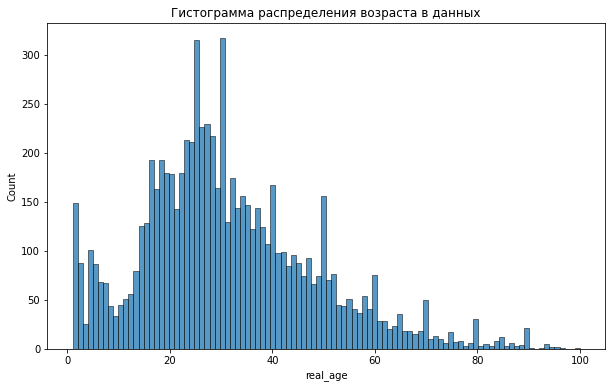

In [7]:
fig = plt.figure(figsize=(10,6))
sns.histplot(data=labels.real_age, bins=100)
plt.title('Гистограмма распределения возраста в данных')
plt.show()

Минимальный возраст: `1 год`. 

Максимальный возраст: `100 лет`.

`25%` данных приходится на возраст до `20 лет`, ещё `25%` на возраст от `20` до `29 лет`.

Средний возраст в датасете - `31 год`, в то время как медианный составляет `29 лет`. Что свидетельсвтует о наличии правого хвоста. 

Посмотрим на дата сет:

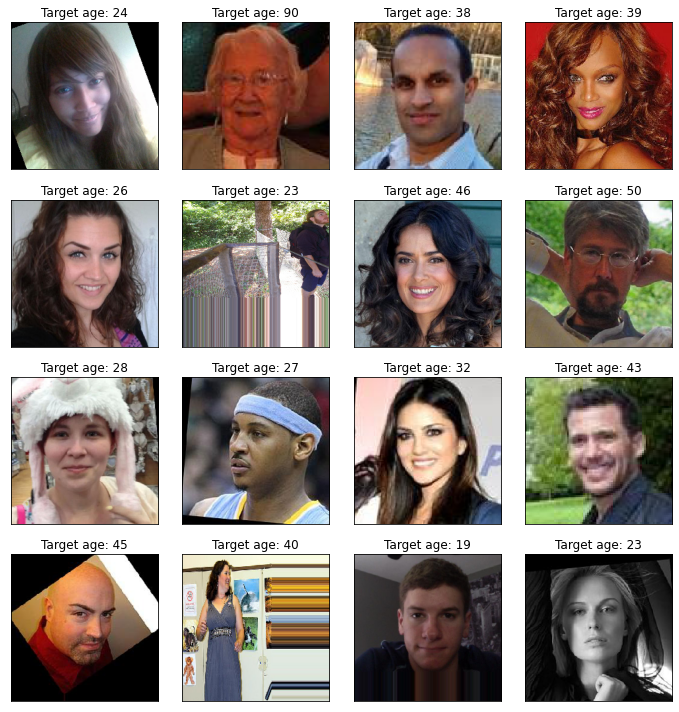

In [16]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.title(f'Target age: {target[i]}')
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Найдем индекс фотографий, которые соответствуют левому и правому хвосту:

In [8]:
right = labels[labels.real_age == 100].index[0]
left = labels[labels.real_age == 1].index[0]

In [9]:
right = load_img('/datasets/faces/final_files/{:06}.jpg'.format(right), target_size=(224, 224))
left = load_img('/datasets/faces/final_files/{:06}.jpg'.format(left), target_size=(224, 224))

Посмотрим на изображения:

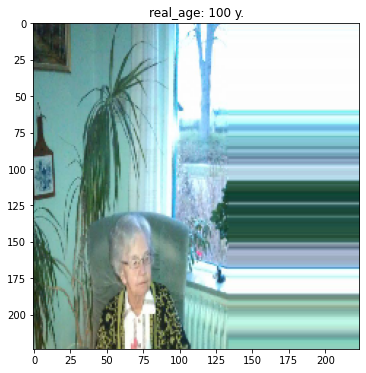

In [21]:
fig = plt.figure(figsize=(9,6))
plt.imshow(right)
plt.title('real_age: 100 y.')
plt.show()

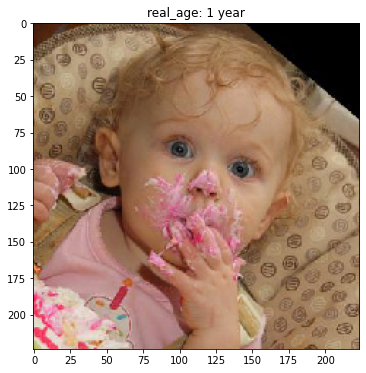

In [22]:
fig = plt.figure(figsize=(9,6))
plt.imshow(left)
plt.title('real_age: 1 year')
plt.show()

Изображения соответствуют заявленному возрасту

## Вывод

Выборка содержит 7591 изображение. И имеет два столбца: `file_name` - фотографию с названием, которая соответствует индексу и `real_age` (целевая метка)

Минимальный возраст: `1 год`, максимальный: `100 лет`.

`25%` данных приходится на возраст до `20 лет`, ещё `25%` на возраст от `20` до `29 лет`.

Средний возраст в датасете - `31 год`, в то время как медианный составляет `29 лет`. Что свидетельствует о наличии правого хвоста. 


Вместе с тем, на фотографии имеются постороннии предметы и объекты. Например: На фотографии из правого хвоста изображение человека занимает лишь ± 25%, в то время как на фотографии из левого хвоста имеются множество посторонних объектов в том числе и на слои с лицом.


# Обучение модели

``` python
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd


def load_train(path):

    df = pd.read_csv('/datasets/faces/labels.csv')

    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        validation_split=0.2)

    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):

    df = pd.read_csv('/datasets/faces/labels.csv')

    valid_datagen = ImageDataGenerator(
        rescale=1. / 255,
        validation_split=0.2)

    validation_gen_flow = valid_datagen.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return validation_gen_flow

def create_model(input_shape):


    backbone = ResNet50(input_shape=(150, 150, 3),
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model
```

В результате обучение модели мы получили:

``` python

Train for 190 steps, validate for 48 steps
Epoch 1/5
2023-08-25 17:03:11.108236: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-08-25 17:03:11.960997: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
190/190 - 77s - loss: 225.3494 - mae: 10.7340 - val_loss: 693.2903 - val_mae: 21.2479
Epoch 2/5
190/190 - 50s - loss: 61.9599 - mae: 5.9436 - val_loss: 730.4219 - val_mae: 21.8977
Epoch 3/5
190/190 - 37s - loss: 29.8906 - mae: 4.2239 - val_loss: 232.5837 - val_mae: 11.1643
Epoch 4/5
190/190 - 37s - loss: 19.8520 - mae: 3.4432 - val_loss: 113.3382 - val_mae: 8.2600
Epoch 5/5
190/190 - 37s - loss: 16.2005 - mae: 3.1383 - val_loss: 78.5604 - val_mae: 6.9254


48/48 - 7s - loss: 78.5604 - mae: 6.9254
```

## Анализ результат

Для обучения была выбрана модель cверточной нейронной сети `ResNet50`. В результате за 5 эпох получилось добиться результата `MAE` - `6.9254`

# Вывод

* Обработка данных:

Выборка содержит 7591 изображение. И имеет два столбца: `file_name` - фотографию с названием, которая соответствует индексу и `real_age` (целевая метка)

Минимальный возраст: `1 год`, максимальный: `100 лет`.

`25%` данных приходится на возраст до `20 лет`, ещё `25%` на возраст от `20` до `29 лет`.

Средний возраст в датасете - `31 год`, в то время как медианный составляет `29 лет`. Что свидетельствует о наличии правого хвоста. 


Вместе с тем, на фотографии имеются постороннии предметы и объекты. Например: На фотографии из правого хвоста изображение человека занимает лишь ± 25%, в то время как на фотографии из левого хвоста имеются множество посторонних объектов в том числе и на слои с лицом.

* Обучение модели

После обучении модели `ResNet50` был получен результат `MAE` - `6.9254`. Данное решение соответствует поставленной задачи: МАЕ < 8.